<a href="https://colab.research.google.com/github/blackbluezk/final-year/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🦟 Malaria Outbreak Prediction System Demo
📡 Available Climate Data Sources:
🌡️ Climate Data Sources for Malaria Modeling

Temperature & Rainfall:
  • World Bank Climate Data: https://climateknowledgeportal.worldbank.org/
  • NASA Giovanni: https://giovanni.gsfc.nasa.gov/giovanni/
  • NOAA Climate Data: https://www.ncdc.noaa.gov/data-access
  • ERA5 Reanalysis: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means

Vegetation Index (NDVI):
  • MODIS Terra/Aqua: https://modis.gsfc.nasa.gov/data/
  • Landsat: https://earthexplorer.usgs.gov/
  • AVHRR NDVI: https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/vh_browse.php

Humidity & Other Meteorological:
  • ERA5: https://cds.climate.copernicus.eu/
  • MERRA-2: https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/
  • JRA-55: https://jra.kishou.go.jp/JRA-55/index_en.html

Integrated Climate APIs:
  • OpenWeatherMap API (historical): https://openweathermap.org/api/statistics-api
  • Visual Crossing: https://w

INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk693rq8z/7kyy8ixz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk693rq8z/zu0au7jq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54058', 'data', 'file=/tmp/tmpk693rq8z/7kyy8ixz.json', 'init=/tmp/tmpk693rq8z/zu0au7jq.json', 'output', 'file=/tmp/tmpk693rq8z/prophet_modelniknpmv4/prophet_model-20250620100033.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:00:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


🧠 Preparing LSTM model for residuals with climate features...
🔄 Training LSTM on residuals with climate integration...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 0.2526 - mae: 0.4676 - val_loss: 0.1453 - val_mae: 0.3597
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1861 - mae: 0.3852 - val_loss: 0.1100 - val_mae: 0.3065
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1504 - mae: 0.3394 - val_loss: 0.0742 - val_mae: 0.2409
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1001 - mae: 0.2624 - val_loss: 0.0430 - val_mae: 0.1627
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0836 - mae: 0.2476 - val_loss: 0.0224 - val_mae: 0.1045
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0606 - mae: 0.1919 - val_loss: 0.0173 - val_mae: 0.1208
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0490 - mae: 0.1696 - val_loss: 0.0214 - val_mae: 0.1336
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0750 - mae: 0.2

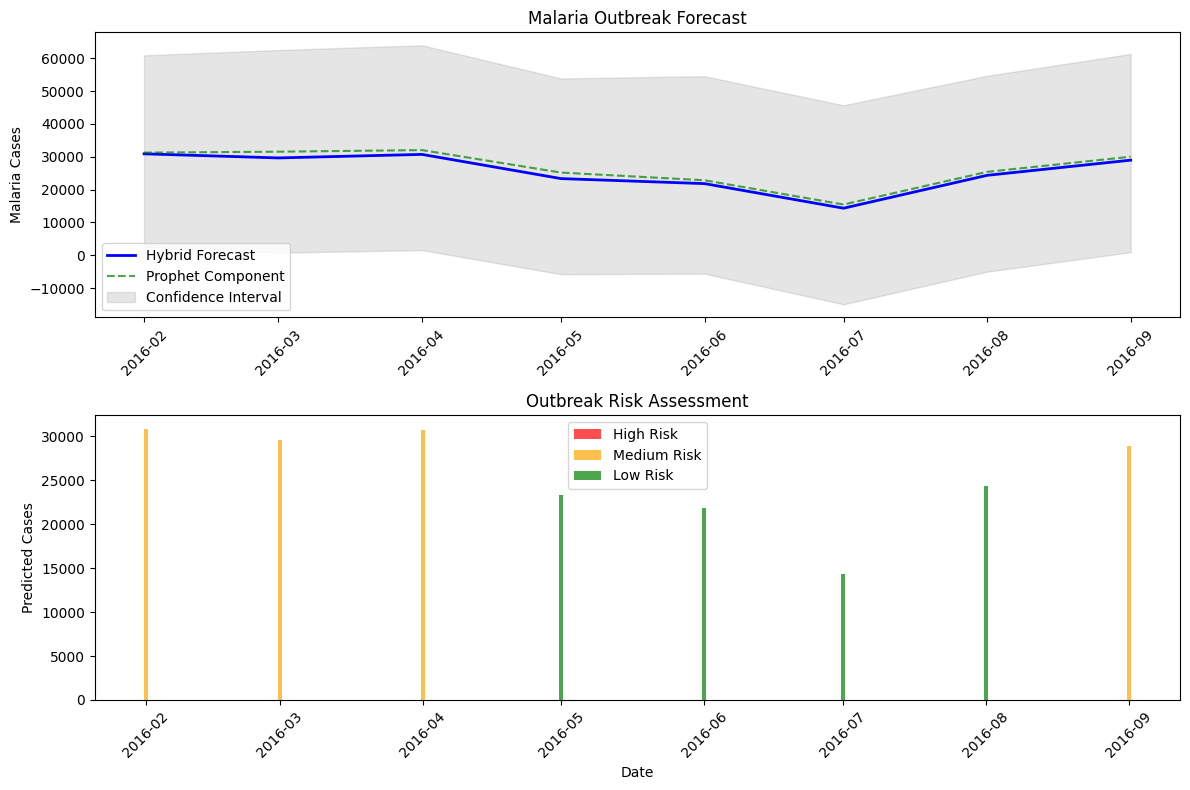


🎯 Key Insights:
• Model integrates climate variables into Prophet as regressors
• LSTM captures residual patterns considering climate history
• Monthly frequency reduces noise compared to daily data
• Climate lags are naturally captured by the lookback window (if used)

🎉 Demo completed successfully!
You can now:
1. Replace sample data with your actual dataset by providing the file path to `run_demo`
2. Adjust model parameters for better performance
3. Deploy the model for real-time predictions
4. Set up automated alert systems
5. Toggle climate data usage with the `use_climate` parameter


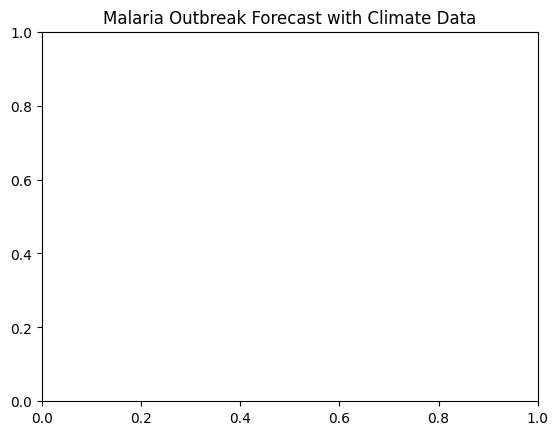

In [57]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import requests # Import requests library
import re # Import re for regular expressions

# Prophet and ML imports
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

class MalariaOutbreakPredictor:
    def __init__(self, lookback_window=3, climate_features=None):
        """
        Hybrid Prophet-LSTM model for malaria outbreak prediction with climate data

        Args:
            lookback_window (int): Number of months to look back for LSTM (default 6)
            climate_features (list): List of climate feature column names
        """
        self.lookback_window = lookback_window
        self.prophet_model = None
        self.lstm_model = None
        self.scaler = MinMaxScaler()
        self.climate_scaler = MinMaxScaler()
        self.is_fitted = False
        # Removed 'vegetation_index' from default climate_features
        self.climate_features = climate_features or [
            'temperature', 'rainfall', 'humidity'
        ]
        if not self.climate_features:  # Ensure it's None if empty list is passed
            self.climate_features = None


    def prepare_data(self, df, date_col='date', target_col='malaria_cases'):
        """
        Prepare monthly data for Prophet-LSTM hybrid model with climate features

        Args:
            df (pd.DataFrame): Input dataframe
            date_col (str): Name of date column
            target_col (str): Name of target variable column

        Returns:
            tuple: (prophet_df, climate_data)
        """
        # Ensure proper datetime format for monthly data
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col])

        # Ensure monthly frequency - take first day of each month
        if df[date_col].dt.day.nunique() > 1:
            df[date_col] = df[date_col].dt.to_period('M').dt.start_time

        df = df.sort_values(date_col).reset_index(drop=True)
        df = df.drop_duplicates(subset=[date_col])

        # Prepare Prophet dataframe
        prophet_df = df[[date_col, target_col]].rename(columns={
            date_col: 'ds',
            target_col: 'y'
        })

        # Extract climate features if available
        available_climate_features = []
        if self.climate_features:
            available_climate_features = [col for col in self.climate_features if col in df.columns]

        climate_data = None

        if available_climate_features:
            climate_data = df[available_climate_features].values
            print(f"🌡️ Using climate features: {available_climate_features}")
        else:
            print("⚠️ No climate features found. Using time-series only model.")

        return prophet_df, climate_data

    def create_lstm_sequences(self, residuals, climate_data=None, lookback=None):
        """Create sequences for LSTM training with optional climate features"""
        if lookback is None:
            lookback = self.lookback_window

        X, y = [], []

        # Adjust the loop start index based on lookback window
        start_index = lookback

        if climate_data is not None and len(climate_data) < start_index:
             raise ValueError(f"Climate data length ({len(climate_data)}) is less than lookback window ({lookback}). Cannot create sequences.")

        for i in range(start_index, len(residuals)):
            # Get residual sequence
            residual_seq = residuals[i-lookback:i]

            if climate_data is not None:
                # Get corresponding climate data sequence
                climate_seq = climate_data[i-lookback:i]
                # Combine residuals and climate data
                combined_seq = np.column_stack([residual_seq.reshape(-1, 1), climate_seq])
                X.append(combined_seq)
            else:
                X.append(residual_seq.reshape(-1, 1))

            y.append(residuals[i])

        return np.array(X), np.array(y)

    def fit(self, df, date_col='date', target_col='malaria_cases',
            validation_split=0.2, epochs=100, batch_size=16):
        """
        Fit the hybrid Prophet-LSTM model with climate data

        Args:
            df (pd.DataFrame): Training data with climate features
            date_col (str): Date column name
            target_col (str): Target column name
            validation_split (float): Fraction of data for validation
            epochs (int): Number of training epochs for LSTM
            batch_size (int): Batch size for LSTM training
        """
        print("📊 Preparing monthly data for hybrid model...")

        # Prepare data with climate features
        prophet_df, climate_data = self.prepare_data(df, date_col, target_col)

        # Step 1: Enhance Prophet model with climate regressors
        print("🔮 Training Prophet model with climate integration...")
        self.prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=0.1,
            holidays_prior_scale=0.1,
            seasonality_mode='multiplicative',
            interval_width=0.95
        )

        # Add climate variables as regressors if available
        available_climate_features = []
        if self.climate_features:
            available_climate_features = [col for col in self.climate_features if col in df.columns]

        prophet_df_with_regressors = prophet_df.copy()

        if available_climate_features:
            for feature in available_climate_features:
                if feature in df.columns:
                    # Add regressor to Prophet
                    self.prophet_model.add_regressor(feature, prior_scale=0.5, mode='additive')
                    # Add feature to prophet dataframe
                    prophet_df_with_regressors[feature] = df[feature].values

        # Add custom seasonalities for malaria
        self.prophet_model.add_seasonality(
            name='quarterly', period=91.25, fourier_order=3  # Quarterly patterns
        )

        self.prophet_model.fit(prophet_df_with_regressors)

        # Generate Prophet predictions for training data
        prophet_forecast = self.prophet_model.predict(prophet_df_with_regressors)

        # Calculate residuals
        residuals = prophet_df['y'].values - prophet_forecast['yhat'].values

        # Step 2: Prepare LSTM data from residuals and climate data
        print("🧠 Preparing LSTM model for residuals with climate features...")

        # Scale residuals
        residuals_scaled = self.scaler.fit_transform(residuals.reshape(-1, 1)).flatten()

        # Scale climate data if available
        climate_data_scaled = None
        if climate_data is not None:
            climate_data_scaled = self.climate_scaler.fit_transform(climate_data)

        # Create sequences
        X_lstm, y_lstm = self.create_lstm_sequences(residuals_scaled, climate_data_scaled)

        if len(X_lstm) == 0:
            raise ValueError(f"Not enough data for LSTM. Need at least {self.lookback_window + 1} data points.")

        # Split data
        split_idx = int(len(X_lstm) * (1 - validation_split))
        X_train, X_val = X_lstm[:split_idx], X_lstm[split_idx:]
        y_train, y_val = y_lstm[:split_idx], y_lstm[split_idx:]

        # Step 3: Build and train LSTM
        print("🔄 Training LSTM on residuals with climate integration...")

        input_features = X_train.shape[2]  # Number of features (residuals + climate)

        self.lstm_model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(self.lookback_window, input_features)),
            Dropout(0.3),
            LSTM(32, return_sequences=False),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dense(1)
        ])

        self.lstm_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        # Early stopping
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )

        # Train LSTM
        history = self.lstm_model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=1
        )

        # Store important data for prediction
        self.last_residuals = residuals_scaled
        self.last_climate_data = climate_data_scaled
        self.prophet_df_with_regressors = prophet_df_with_regressors

        self.is_fitted = True
        self.training_history = history

        print("✅ Hybrid model training completed!")

        return self

    def predict(self, periods=12, future_climate_data=None):
        """
        Make predictions using the hybrid model with climate data

        Args:
            periods (int): Number of months to forecast
            future_climate_data (np.array): Future climate data for forecast period

        Returns:
            pd.DataFrame: Predictions with confidence intervals
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        print(f"🔮 Generating {periods} month forecast...")

        # Create future dates (monthly)
        last_date = self.prophet_df_with_regressors['ds'].max()
        future_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=periods,
            freq='MS'  # Month start
        )

        future_df = pd.DataFrame({'ds': future_dates})

        # Add climate regressors if they were used in training
        available_climate_features = []
        if self.climate_features:
            available_climate_features = [col for col in self.climate_features
                                    if col in self.prophet_df_with_regressors.columns]

        if available_climate_features:
            if future_climate_data is not None:
                # Use provided future climate data
                for i, feature in enumerate(available_climate_features):
                    if i < future_climate_data.shape[1]:
                        future_df[feature] = future_climate_data[:, i]
            else:
                # Use last known values or seasonal averages as fallback
                print("⚠️ No future climate data provided. Using seasonal averages.")
                for feature in available_climate_features:
                    # Use seasonal average based on month
                    monthly_avg = self.prophet_df_with_regressors.groupby(
                        self.prophet_df_with_regressors['ds'].dt.month
                    )[feature].mean()

                    future_months = future_df['ds'].dt.month
                    future_df[feature] = future_months.map(monthly_avg)

        # Prophet forecast
        prophet_forecast = self.prophet_model.predict(future_df)

        # LSTM residual prediction
        if hasattr(self, 'last_residuals') and self.lstm_model is not None:
            # Use the last few residuals to predict future residuals
            recent_residuals = self.last_residuals[-self.lookback_window:]
            lstm_residuals = []

            current_residuals = recent_residuals.copy()

            for i in range(periods):
                # Prepare LSTM input
                if self.last_climate_data is not None and future_climate_data is not None:
                    # Use climate data
                    if i < len(future_climate_data):
                        # Ensure future_climate_data has the same number of features as climate_data_scaled
                        if future_climate_data.shape[1] == self.climate_scaler.n_features_in_:
                            climate_input = self.climate_scaler.transform(
                                future_climate_data[i:i+1]
                            )
                            lstm_input = np.column_stack([
                                current_residuals.reshape(-1, 1),
                                np.tile(climate_input, (self.lookback_window, 1))
                            ])
                        else:
                             print(f"⚠️ Future climate data has {future_climate_data.shape[1]} features, but expected {self.climate_scaler.n_features_in_}. Using residuals only for LSTM prediction.")
                             lstm_input = current_residuals.reshape(-1, 1)

                    else:
                        # Fallback to last known climate values
                        last_climate = self.last_climate_data[-1:].reshape(1, -1)
                        lstm_input = np.column_stack([
                            current_residuals.reshape(-1, 1),
                            np.tile(last_climate, (self.lookback_window, 1))
                        ])
                else:
                    # Residuals only
                    lstm_input = current_residuals.reshape(-1, 1)

                # Ensure the input shape matches what the LSTM was trained on
                expected_input_features = self.lstm_model.input_shape[-1]
                if lstm_input.shape[-1] != expected_input_features:
                     # If climate data is missing or doesn't match, pad or truncate
                     if lstm_input.shape[-1] < expected_input_features:
                         # Pad with zeros if fewer features
                         padding = np.zeros((lstm_input.shape[0], expected_input_features - lstm_input.shape[-1]))
                         lstm_input = np.hstack([lstm_input, padding])
                     elif lstm_input.shape[-1] > expected_input_features:
                         # Truncate if more features
                         lstm_input = lstm_input[:, :expected_input_features]


                lstm_input = lstm_input.reshape(1, self.lookback_window, expected_input_features)


                # Predict next residual
                next_residual_scaled = self.lstm_model.predict(lstm_input, verbose=0)[0, 0]
                next_residual = self.scaler.inverse_transform(
                    [[next_residual_scaled]]
                )[0, 0]

                lstm_residuals.append(next_residual)

                # Update current residuals for next iteration
                current_residuals = np.append(current_residuals[1:], next_residual_scaled)
        else:
            # Fallback: assume residuals decay to zero
            lstm_residuals = np.zeros(periods)

        # Combine predictions
        final_predictions = prophet_forecast['yhat'].values + np.array(lstm_residuals)

        # Create results dataframe
        results = pd.DataFrame({
            'date': future_dates,
            'prophet_prediction': prophet_forecast['yhat'].values,
            'lstm_residual': lstm_residuals,
            'final_prediction': np.maximum(0, final_predictions),  # Ensure non-negative
            'prophet_lower': prophet_forecast['yhat_lower'].values,
            'prophet_upper': prophet_forecast['yhat_upper'].values,
        })

        # Add outbreak risk assessment
        if not results['final_prediction'].empty:
            mean_prediction = results['final_prediction'].mean()
            std_prediction = results['final_prediction'].std()

            results['outbreak_risk'] = results['final_prediction'].apply(
                lambda x: 'High' if x > mean_prediction + std_prediction else
                         'Medium' if x > mean_prediction else 'Low'
            )
        else:
             results['outbreak_risk'] = 'Low' # Default to Low if no predictions


        return results

    def evaluate(self, df, date_col='date', target_col='malaria_cases'):
        """Evaluate model performance"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before evaluation")

        # Prepare data for evaluation, including regressors
        eval_df = df.copy()
        eval_df[date_col] = pd.to_datetime(eval_df[date_col])
        eval_df = eval_df.rename(columns={date_col: 'ds', target_col: 'y'})

        # Ensure climate regressors are present in the evaluation dataframe
        available_climate_features = []
        if self.climate_features:
            available_climate_features = [col for col in self.climate_features
                                    if col in eval_df.columns]

        # Create the dataframe for prediction, including ds and regressors
        predict_df = eval_df[['ds']]
        if available_climate_features:
            predict_df = predict_df.merge(eval_df[available_climate_features],
                                          on='ds', how='left') # Merge on 'ds'

        prophet_forecast = self.prophet_model.predict(predict_df)

        # Basic metrics
        actual = eval_df['y'].values
        predicted = prophet_forecast['yhat'].values

        metrics = {
            'MAE': mean_absolute_error(actual, predicted),
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'R2': r2_score(actual, predicted),
            'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100
        }

        return metrics

    def plot_forecast(self, predictions, title="Malaria Outbreak Forecast"):
        """Plot forecast results"""
        plt.figure(figsize=(12, 8))

        # Main prediction plot
        plt.subplot(2, 1, 1)
        plt.plot(predictions['date'], predictions['final_prediction'],
                'b-', linewidth=2, label='Hybrid Forecast')
        plt.plot(predictions['date'], predictions['prophet_prediction'],
                'g--', alpha=0.7, label='Prophet Component')
        plt.fill_between(predictions['date'],
                        predictions['prophet_lower'],
                        predictions['prophet_upper'],
                        alpha=0.2, color='gray', label='Confidence Interval')
        plt.title(title)
        plt.ylabel('Malaria Cases')
        plt.legend()
        plt.xticks(rotation=45)

        # Risk assessment plot
        plt.subplot(2, 1, 2)
        risk_colors = {'High': 'red', 'Medium': 'orange', 'Low': 'green'}
        colors = [risk_colors[risk] for risk in predictions['outbreak_risk']]
        plt.bar(predictions['date'], predictions['final_prediction'],
                color=colors, alpha=0.7)
        plt.title('Outbreak Risk Assessment')
        plt.ylabel('Predicted Cases')
        plt.xlabel('Date')
        plt.xticks(rotation=45)

        # Add legend for risk levels
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', alpha=0.7, label='High Risk'),
                          Patch(facecolor='orange', alpha=0.7, label='Medium Risk'),
                          Patch(facecolor='green', alpha=0.7, label='Low Risk')]
        plt.legend(handles=legend_elements)

        plt.tight_layout()
        plt.show()

    def get_outbreak_alerts(self, predictions, threshold_percentile=75):
        """Generate outbreak alerts"""
        if predictions.empty or 'final_prediction' not in predictions.columns:
             return pd.DataFrame() # Return empty if no predictions

        threshold = np.percentile(predictions['final_prediction'], threshold_percentile)
        alerts = predictions[predictions['final_prediction'] > threshold].copy()

        if len(alerts) > 0:
            # Ensure there's enough data to calculate percentiles for alert levels
            if len(predictions['final_prediction']) >= 10: # Arbitrary threshold, adjust as needed
                critical_threshold = np.percentile(predictions['final_prediction'], 90)
                high_threshold = np.percentile(predictions['final_prediction'], 80)
                alerts['alert_level'] = alerts['final_prediction'].apply(
                    lambda x: 'CRITICAL' if x > critical_threshold
                             else 'HIGH' if x > high_threshold
                             else 'MODERATE'
                )
            else:
                # If not enough data, simplify alerts
                alerts['alert_level'] = alerts['final_prediction'].apply(
                    lambda x: 'HIGH' if x > threshold else 'MODERATE' # Or just 'ALERT'
                )


            return alerts[['date', 'final_prediction', 'alert_level']]
        else:
            return pd.DataFrame()

# Example usage and testing function
def create_sample_data():
    """Create sample monthly malaria data with climate variables for testing"""
    np.random.seed(42)

    # Create monthly date range
    dates = pd.date_range(start='2018-01-01', end='2023-12-01', freq='MS')
    n_months = len(dates)

    # Simulate climate variables
    t = np.arange(n_months)

    # Temperature (cyclical with trend)
    temperature = 25 + 5 * np.sin(2 * np.pi * t / 12) + 0.02 * t + np.random.normal(0, 1, n_months)

    # Rainfall (higher during rainy season)
    rainfall = 50 + 40 * np.sin(2 * np.pi * (t - 3) / 12) + np.random.exponential(20, n_months)
    rainfall = np.maximum(0, rainfall)

    # Humidity (correlated with rainfall)
    humidity = 60 + 0.3 * rainfall + 10 * np.sin(2 * np.pi * t / 12) + np.random.normal(0, 3, n_months)
    humidity = np.clip(humidity, 30, 95)

    # Removed vegetation index simulation

    # Malaria cases (influenced by climate with lags)
    # Base seasonal pattern
    seasonal = 30 * np.sin(2 * np.pi * (t - 2) / 12)  # Peak 2 months after rain

    # Climate effects (with realistic lags)
    temp_effect = 2 * (temperature - 25)  # Optimal around 25°C
    rainfall_effect = 0.1 * np.maximum(0, rainfall - 30)  # Threshold effect
    humidity_effect = 0.2 * (humidity - 60)
    # Removed vegetation effect

    # Base trend
    trend = 80 + 0.5 * t

    # Combine all effects
    malaria_mean = (trend + seasonal + temp_effect +
                   rainfall_effect + humidity_effect) # Removed vegetation effect

    # Add noise and ensure positive values
    noise = np.random.normal(0, 8, n_months)
    malaria_cases = np.maximum(5, malaria_mean + noise)

    # Add occasional outbreak spikes
    outbreak_months = np.random.choice(n_months, size=8, replace=False)
    malaria_cases[outbreak_months] += np.random.exponential(40, 8)

    df = pd.DataFrame({
        'date': dates,
        'malaria_cases': malaria_cases.astype(int),
        'temperature': np.round(temperature, 1),
        'rainfall': np.round(rainfall, 1),
        'humidity': np.round(humidity, 1),
        # Removed vegetation_index column
    })

    return df

def get_climate_data_sources():
    """Information about climate data sources for malaria modeling"""
    sources = {
        'Temperature & Rainfall': [
            'World Bank Climate Data: https://climateknowledgeportal.worldbank.org/',
            'NASA Giovanni: https://giovanni.gsfc.nasa.gov/giovanni/',
            'NOAA Climate Data: https://www.ncdc.noaa.gov/data-access',
            'ERA5 Reanalysis: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means'
        ],
        'Vegetation Index (NDVI)': [ # Kept for informational purposes but noted as out of scope
            'MODIS Terra/Aqua: https://modis.gsfc.nasa.gov/data/',
            'Landsat: https://earthexplorer.usgs.gov/',
            'AVHRR NDVI: https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/vh_browse.php'
        ],
        'Humidity & Other Meteorological': [
            'ERA5: https://cds.climate.copernicus.eu/',
            'MERRA-2: https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/',
            'JRA-55: https://jra.kishou.go.jp/JRA-55/index_en.html'
        ],
        'Integrated Climate APIs': [
            'OpenWeatherMap API (historical): https://openweathermap.org/api/statistics-api',
            'Visual Crossing: https://www.visualcrossing.com/weather-api',
            'World Weather Online: https://www.worldweatheronline.com/developer/api/'
        ]
    }

    print("🌡️ Climate Data Sources for Malaria Modeling")
    print("=" * 50)
    for category, urls in sources.items():
        print(f"\n{category}:")
        for url in urls:
            print(f"  • {url}")

    print(f"\n📋 Recommended Monthly Climate Variables (excluding Vegetation Index):")
    print("  • Temperature (°C) - monthly average")
    print("  • Rainfall (mm) - monthly total")
    print("  • Humidity (%) - monthly average")
    # Removed vegetation index from recommended list
    print("  • Optional: Wind speed, solar radiation, soil moisture")

    return sources



def load_and_prepare_malaria(filepath):
    """
    Loads raw malaria CSV with single header and returns monthly totals.
    Assumes:
    - First row is the header containing identifying information and month-year columns (e.g., 'Oct-13').
    - Data starts on the second row.
    - Columns with 'Mon-YY' format contain malaria case data.
    """
    try:
        # Read the raw CSV, assuming the first row is the header
        df_raw = pd.read_csv(filepath, header=0)

        # Drop the unnamed column if it exists (like 'Unnamed: 4' from inspection)
        df_raw = df_raw.loc[:, ~df_raw.columns.str.contains('^Unnamed')]

        # Identify identifier columns (State, LGA, Ward, Health Facility)
        # Assuming these are the first few columns based on file inspection,
        # and are NOT in the 'Mon-YY' format
        id_vars = [col for col in df_raw.columns if not re.match(r'[A-Za-z]{3}-\d{2}', col)]

        # Identify columns that are date-formatted (e.g., 'Oct-13', 'Nov-13')
        # These are the columns to be melted
        date_cols = [col for col in df_raw.columns if re.match(r'[A-Za-z]{3}-\d{2}', col)]

        if not date_cols:
            raise ValueError("Could not find any columns with 'Mon-YY' date format. Check header format.")

        # Melt the dataframe to long format
        # Use all identified non-'Mon-YY' columns as id_vars
        df_long = df_raw.melt(id_vars=id_vars, value_vars=date_cols, var_name='header', value_name='cases')

        # Convert 'cases' to numeric, coercing errors to NaN and then filling with 0
        df_long['cases'] = pd.to_numeric(df_long['cases'], errors='coerce').fillna(0)

        # Extract year and month from the header string using a flexible regex for 'Mon-YY'
        date_pattern = r'([A-Za-z]{3})-(\d{2})'
        date_info = df_long['header'].str.extract(date_pattern, expand=True)

        if date_info.empty or date_info[0].isnull().all():
            raise ValueError("Could not extract year and month from column headers using 'Mon-YY' pattern.")

        df_long['month_name'] = date_info[0]
        # Convert 2-digit year to 4-digit year (e.g., '13' -> '2013')
        # This assumes years are in the 2000s. Adjust if years like '98' are possible.
        df_long['year'] = date_info[1].apply(lambda x: int(f'20{x}'))


        month_map = {
            'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
            'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
        }
        df_long['month'] = df_long['month_name'].str.upper().map(month_map)

        # Drop rows where date extraction or mapping failed
        df_long = df_long.dropna(subset=['year', 'month'])

        if df_long.empty:
            raise ValueError("No valid monthly data extracted after parsing headers and dates.")

        # Create datetime objects for the first day of each month
        df_long['date'] = pd.to_datetime(dict(
            year=df_long['year'].astype(int),
            month=df_long['month'].astype(int),
            day=1
        ))

        # Group by date and sum cases for each month
        monthly = df_long.groupby('date', as_index=False)['cases'].sum()

        return monthly

    except Exception as e:
        print(f"Error loading and preparing malaria data: {e}")
        # Return empty DataFrame if loading fails
        return pd.DataFrame({'date': [], 'cases': []})


def prepare_your_data(malaria_df, climate_df=None,
                      date_col='date', malaria_col='cases',
                      merge_on_date=True):
    """
    Prepares cleaned malaria (and optionally climate) data for modeling.

    Args:
        malaria_df: DataFrame with columns [date, cases]
        climate_df: DataFrame with [date, temperature, rainfall, ...] (optional)
        date_col: Column to merge on
        malaria_col: Name of column holding case totals
        merge_on_date: Whether to join on date

    Returns:
        Cleaned, optionally merged DataFrame
    """
    df = malaria_df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    # Check if malaria_col exists before grouping
    if malaria_col not in df.columns:
        raise ValueError(f"Target column '{malaria_col}' not found in the malaria data.")
    df = df.groupby(date_col)[malaria_col].sum().reset_index()


    if climate_df is not None and merge_on_date:
        climate_df = climate_df.copy()
        climate_df[date_col] = pd.to_datetime(climate_df[date_col], errors='coerce')
        df = df.merge(climate_df, on=date_col, how='left')

    df = df.sort_values(date_col).reset_index(drop=True)

    print(f"✅ Prepared {len(df)} months of data")
    if not df.empty:
        print(f"📅 Date range: {df[date_col].min()} → {df[date_col].max()}")
    print(f"📦 Columns: {list(df.columns)}")

    return df


# Demo function
def run_demo(malaria_filepath, climate_filepath=None, use_climate=True):
    """Run a complete demo of the malaria prediction system with optional climate data"""
    print("🦟 Malaria Outbreak Prediction System Demo")
    print("=" * 60)

    # Show climate data sources only if climate data is intended to be used
    if use_climate:
        print("📡 Available Climate Data Sources:")
        sources = get_climate_data_sources()
    else:
        print("⚠️ Running without climate data.")


    # Load or create malaria data
    malaria_df = pd.DataFrame() # Initialize as empty
    malaria_col = None # Initialize malaria_col
    malaria_data_loaded_successfully = False # Flag to track if malaria data was successfully loaded/created

    if malaria_filepath:
        print(f"\n📊 Loading malaria data from {malaria_filepath}...")
        try:
            malaria_df = load_and_prepare_malaria(malaria_filepath)
            if not malaria_df.empty:
                malaria_col = 'cases' # The column name after loading from the specific format
                malaria_data_loaded_successfully = True
                print(f"Loaded and prepared {len(malaria_df)} months of malaria data from file.")
            else:
                print("⚠️ Loaded dataframe from file is empty. Falling back to sample data.")
        except Exception as e:
            print(f"❌ Failed to load malaria data from {malaria_filepath}: {e}")
            print("⚠️ Falling back to sample malaria data.")

    # If malaria_df is still empty (either no filepath provided or loading failed), create sample data
    if not malaria_data_loaded_successfully:
        print("\n📊 Creating sample malaria data...")
        # Ensure create_sample_data returns the correct columns for the fallback
        sample_df_malaria = create_sample_data()
        malaria_df = sample_df_malaria[['date', 'malaria_cases']].copy() # Get only date and malaria cases
        malaria_col = 'malaria_cases'
        print(f"Generated {len(malaria_df)} months of sample malaria data.")


    # Load or fetch climate data ONLY if use_climate is True
    climate_df = pd.DataFrame() # Initialize as empty
    climate_data_loaded_successfully = False # Flag to track if climate data was successfully loaded/created

    if use_climate:
        if climate_filepath:
            print(f"\n☁️ Loading climate data from {climate_filepath}...")
            try:
                # Assuming climate data file is a simple CSV with date and climate columns
                climate_df = pd.read_csv(climate_filepath)
                climate_df['date'] = pd.to_datetime(climate_df['date'], errors='coerce')
                climate_df = climate_df.dropna(subset=['date']) # Drop rows with invalid dates
                # Ensure climate columns have numeric types, coercing errors
                # Filter for the expected climate features
                expected_climate_cols = [f for f in ['temperature', 'rainfall', 'humidity'] if f in climate_df.columns]
                for col in expected_climate_cols:
                     climate_df[col] = pd.to_numeric(climate_df[col], errors='coerce')
                climate_df = climate_df[['date'] + expected_climate_cols] # Select relevant columns


                if not climate_df.empty:
                    climate_data_loaded_successfully = True
                    print(f"Loaded and prepared {len(climate_df)} months of climate data from file.")
                    if not climate_df.empty:
                        print(f"Climate data date range: {climate_df['date'].min()} to {climate_df['date'].max()}")
                else:
                    print("⚠️ Loaded climate dataframe from file is empty. Falling back to API/sample data.")
            except Exception as e:
                print(f"❌ Failed to load climate data from {climate_filepath}: {e}")
                print("⚠️ Falling back to API or sample climate data.")


        # If climate data was not loaded from file, try fetching from API
        if not climate_data_loaded_successfully:
            print("\n☁️ Attempting to fetch actual climate data from World Bank API...")
            # Updated the URL to only include temperature, rainfall, and humidity
            url = "https://ckkpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_hurs,pr,tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean/NGA?_format=json"
            try:
                data = requests.get(url).json()
                print("🔑 World Bank API Response Structure:") # Debug print
                print(data) # Debug print

                records = []
                for indicator in data['data']:
                    var = indicator['indicator']
                    for entry in indicator['monthlyData']:
                        year = entry['year']
                        # Correctly iterate through the monthVals list
                        for month_idx, val in enumerate(entry.get('monthVals', []), start=1):
                            records.append({
                                "year": year,
                                "month": month_idx,
                                "indicator": var,
                                "value": val
                            })

                climate_df = pd.DataFrame(records)
                climate_df = climate_df.pivot_table(index=["year", "month"], columns="indicator", values="value").reset_index()
                climate_df['date'] = pd.to_datetime(climate_df['year'].astype(str) + '-' + climate_df['month'].astype(str) + '-01')
                climate_df = climate_df.rename(columns={'hurs': 'humidity', 'pr': 'rainfall', 'tas': 'temperature'}) # Rename columns to match expected climate features
                # Check if the required climate columns exist after renaming
                required_climate_cols = ['date', 'temperature', 'rainfall', 'humidity']
                climate_df = climate_df[[col for col in required_climate_cols if col in climate_df.columns]] # Select relevant columns that exist


                if not climate_df.empty:
                     climate_data_loaded_successfully = True
                     print(f"Fetched {len(climate_df)} months of climate data from API.")
                     print(f"Climate data date range: {climate_df['date'].min()} to {climate_df['date'].max()}")
                else:
                    print("⚠️ Fetched climate dataframe is empty. Falling back to sample data.")

            except Exception as e:
                print(f"❌ Failed to fetch climate data: {e}")
                print("⚠️ Using sample climate data instead.")

        # If climate_df is still empty (either fetching failed or resulted in empty df), create sample data
        if not climate_data_loaded_successfully:
            print("☁️ Creating sample climate data...")
            sample_df_climate = create_sample_data() # create_sample_data now excludes vegetation_index
            # Ensure we only use climate features that are defined in the class
            # Updated available_sample_climate_features to exclude vegetation_index
            available_sample_climate_features = [col for col in ['date', 'temperature', 'rainfall', 'humidity'] if col in sample_df_climate.columns]
            climate_df = sample_df_climate[available_sample_climate_features].copy()
            print(f"Using {len(climate_df)} months of sample climate data.")


    # Combine malaria and climate data ONLY if use_climate is True
    if use_climate:
        print("\n merging malaria and climate data...")
        # Use prepare_your_data to merge the sample malaria data with the fetched (or sample) climate data
        if not malaria_df.empty and not climate_df.empty:
            df = prepare_your_data(malaria_df, climate_df, date_col='date', malaria_col=malaria_col, merge_on_date=True)
        elif not malaria_df.empty and climate_df.empty:
             print("⚠️ Climate data is empty. Proceeding with malaria data only.")
             df = prepare_your_data(malaria_df, None, date_col='date', malaria_col=malaria_col, merge_on_date=False)
        else:
            print("❌ Malaria data is empty. Cannot prepare combined data.")
            df = pd.DataFrame() # Ensure df is an empty DataFrame
    else:
        # If not using climate data, just use the malaria data
        print("\n Preparing malaria data (climate data excluded)...")
        if not malaria_df.empty:
             df = prepare_your_data(malaria_df, None, date_col='date', malaria_col=malaria_col, merge_on_date=False)
        else:
             print("❌ Malaria data is empty. Cannot prepare data.")
             df = pd.DataFrame() # Ensure df is an empty DataFrame


    print(f"\nCombined data: {len(df)} months")
    print(f"Columns: {list(df.columns)}")
    if not df.empty:
        print(f"Date range: {df['date'].min()} → {df['date'].max()}")


    # Show sample statistics
    print("\n📈 Data Summary:")
    print(df.describe().round(2))

    # Split data for training and testing
    if len(df) < 2:
         print("\n❌ Not enough data to train the model.")
         return None, None, None, df # Exit demo if insufficient data

    train_size = int(len(df) * 0.8)
    train_df = df[:train_size]
    test_df = df[train_size:]

    print(f"\nTraining data: {len(train_df)} months")
    print(f"Test data: {len(test_df)} months")

    # Initialize and train model with climate features ONLY if use_climate is True
    print("\n🤖 Initializing hybrid Prophet-LSTM model...")
    climate_features = []
    if use_climate:
        print("with climate integration...")
        # Ensure climate_features match the columns in the combined dataframe
        # Updated climate_features list
        climate_features = [col for col in ['temperature', 'rainfall', 'humidity'] if col in df.columns]

    model = MalariaOutbreakPredictor(
        lookback_window = 4,  # 6 months lookback for monthly data
        climate_features=climate_features if use_climate else None # Pass None if not using climate
    )

    print("🎯 Training model...")
    if use_climate:
        print("with climate data...")
    else:
        print("without climate data...")

    # Check if the target column exists in the training data before fitting
    if malaria_col not in train_df.columns:
        print(f"❌ Target column '{malaria_col}' not found in training data. Cannot train model.")
        return None, None, None, df

    # Drop rows with NaNs in climate features before training if climate features are used
    if use_climate and climate_features:
        initial_train_rows = len(train_df)
        train_df = train_df.dropna(subset=climate_features)
        if len(train_df) < initial_train_rows:
            print(f"⚠️ Dropped {initial_train_rows - len(train_df)} rows with NaN climate data from training set.")

    if train_df.empty:
         print("\n❌ Training data is empty after dropping NaNs. Cannot train model.")
         return None, None, None, df


    model.fit(train_df, epochs=50, batch_size=8, target_col=malaria_col) # Pass the target_col


    # Prepare future climate data for prediction (using test data as proxy) ONLY if use_climate is True
    future_climate = climate_df
    if use_climate and climate_features:
        # Ensure future_climate has the same columns as climate_features used in training
        # Filter test_df to only include the climate features used
        future_climate_df = test_df[climate_features].copy()
        future_climate = future_climate_df.values[:8]  # Next 8 months (matching prediction periods)
        # Handle potential NaNs in future_climate data - use mean or previous valid value?
        # For demo purposes, fill with mean from training data
        if climate_features and not train_df.empty:
            for i, feature in enumerate(climate_features):
                 if feature in train_df.columns:
                     mean_val = train_df[feature].mean()
                     if future_climate is not None and future_climate.shape[1] > i:
                          future_climate[:, i] = np.nan_to_num(future_climate[:, i], nan=mean_val)


    # Make predictions
    print("\n🔮 Making predictions...")
    if use_climate and future_climate is not None and future_climate.shape[0] > 0:
        print("with climate data...")
        predictions = model.predict(periods=8, future_climate_data=future_climate)
    elif not use_climate:
         print("without climate data...")
         predictions = model.predict(periods=8) # Predict without climate if not used
    else:
         print("⚠️ Not enough future climate data for prediction. Skipping prediction.")
         predictions = pd.DataFrame() # Empty dataframe if no future climate data


    # Evaluate performance on training data
    if not train_df.empty:
        print("\n📈 Model Performance:")
        metrics = model.evaluate(train_df, target_col=malaria_col) # Pass the target_col
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    else:
        print("\n⚠️ Cannot evaluate model performance as training data is empty.")


    # Generate alerts
    if not predictions.empty:
        alerts = model.get_outbreak_alerts(predictions)
        if len(alerts) > 0:
            print(f"\n🚨 {len(alerts)} outbreak alerts generated!")
            print(alerts.head())
        else:
            print("\n✅ No outbreak alerts for the forecast period")
    else:
         print("\n⚠️ Cannot generate alerts as prediction results are empty.")


    # Show climate impact ONLY if use_climate is True
    if use_climate:
        print("\n🌡️ Climate Variables Impact:")
        # Ensure climate impact print statements use the actual climate features
        if climate_features and not test_df.empty:
            for feature in climate_features:
                if feature in test_df.columns:
                    print(f"{feature.capitalize()} range in forecast period:",
                        f"{test_df[feature].min():.1f} - {test_df[feature].max():.1f}")
        elif climate_features and test_df.empty:
            print("⚠️ Cannot show climate variable impact as test data is empty.")
        else:
            print("✅ No climate features were used in the model.")
    else:
        print("\n🌡️ Climate Variables Impact: (Climate data not used in this run)")


    # Plot results
    if not predictions.empty:
        print("\n📊 Plotting forecast...")
        model.plot_forecast(predictions, "Malaria Outbreak Forecast")
        if use_climate:
            plt.title("Malaria Outbreak Forecast with Climate Data")
        else:
            plt.title("Malaria Outbreak Forecast (Time-Series Only)")

    else:
        print("\n⚠️ Cannot plot forecast as prediction results is empty.")


    # Show feature importance insights
    print("\n🎯 Key Insights:")
    if use_climate:
        print("• Model integrates climate variables into Prophet as regressors")
        print("• LSTM captures residual patterns considering climate history")
    else:
        print("• Model uses Prophet for seasonality and trend, and LSTM for residuals")

    print("• Monthly frequency reduces noise compared to daily data")
    print("• Climate lags are naturally captured by the lookback window (if used)")

    return model, predictions, alerts, df


if __name__ == "__main__":
    # Run the demo
    # To use your own data, replace None with the path to your malaria data CSV file
    # To use your own climate data, replace None with the path to your climate data CSV file
    # To run WITHOUT climate data, set use_climate=False
    model, predictions, alerts, df = run_demo(malaria_filepath='katsina.csv', climate_filepath='katsina climate.csv', use_climate=True)

    print("\n" + "="*50)
    print("🎉 Demo completed successfully!")
    print("You can now:")
    print("1. Replace sample data with your actual dataset by providing the file path to `run_demo`")
    print("2. Adjust model parameters for better performance")
    print("3. Deploy the model for real-time predictions")
    print("4. Set up automated alert systems")
    print("5. Toggle climate data usage with the `use_climate` parameter")

# Task
Develop a web application to predict malaria cases and generate outbreak alerts based on climate data, deploy the frontend to Vercel, and connect it to a backend API.

## Develop a web api

### Subtask:
Create a simple web API (e.g., using Flask or FastAPI in Python) that loads the trained model and exposes an endpoint for predictions. This API will take input data (including climate features if used) and return malaria case predictions and outbreak alerts.


**Reasoning**:
The subtask requires creating a web API to expose the trained model. This involves selecting a framework, defining an endpoint, loading the model, processing requests, and returning predictions. Flask is a suitable simple framework for this. We will define the Flask application, load the model (assuming it was saved), define the `/predict` endpoint to accept JSON input, use the model to make predictions and generate alerts, and return the results as JSON. We'll also include basic error handling.



In [58]:
import pickle
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np # Make sure numpy is imported if used by the model

# Assuming the trained model object is available after running the previous cell
# For production, you would load the saved model:
# try:
#     with open('malaria_model.pkl', 'rb') as f:
#         model = pickle.load(f)
# except FileNotFoundError:
#     print("Error: Model file not found. Please train and save the model first.")
#     model = None # Handle case where model is not loaded

# For the demo, we assume the 'model' variable is available from the previous run
# In a real scenario, you would save the model after training and load it here.
# Example of saving the model after training in the run_demo function:
# with open('malaria_model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# Check if the model variable exists and is not None
if 'model' not in locals() or model is None:
    print("Attempting to load the model from a file...")
    try:
        # Assuming the model was saved as 'malaria_model.pkl'
        with open('malaria_model.pkl', 'rb') as f:
            model = pickle.load(f)
        print("Model loaded successfully from 'malaria_model.pkl'")
    except FileNotFoundError:
        print("Error: 'malaria_model.pkl' not found. Please ensure the model is trained and saved.")
        # As a fallback for demo purposes, try re-running the demo to get the model
        print("Attempting to run the demo to generate a model...")
        try:
             # Assuming run_demo function exists and can generate a model
             # This is not ideal for a production API but works for a demo environment
             model, predictions, alerts, df = run_demo(malaria_filepath='katsina.csv', climate_filepath='katsina climate.csv', use_climate=True)
             if model is not None:
                  print("Model generated from demo run.")
                  # Optional: Save the newly generated model
                  # with open('malaria_model.pkl', 'wb') as f:
                  #     pickle.dump(model, f)
                  # print("Model saved as 'malaria_model.pkl'")
             else:
                  print("Error: Failed to generate model from demo run.")
        except Exception as e:
             print(f"Error during demo run fallback: {e}")
             model = None # Ensure model is None if fallback fails


app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    if model is None:
        return jsonify({"error": "Model is not loaded."}), 500

    try:
        data = request.get_json()
        if not data:
            return jsonify({"error": "Invalid JSON data provided."}), 400

        periods = data.get('periods', 8) # Default to 8 periods if not provided
        future_climate_data = data.get('future_climate_data')

        # Validate future_climate_data format if provided
        if future_climate_data is not None:
            try:
                future_climate_data = np.array(future_climate_data)
                # Basic shape validation (optional but recommended)
                # Check if number of columns matches expected climate features
                if model.climate_features and future_climate_data.shape[1] != len(model.climate_features):
                    return jsonify({"error": f"future_climate_data has {future_climate_data.shape[1]} columns, but the model expects {len(model.climate_features)} climate features."}), 400
                if future_climate_data.shape[0] != periods:
                     print(f"Warning: Provided future_climate_data has {future_climate_data.shape[0]} periods, but prediction is requested for {periods} periods. Using only the first {periods} rows.")
                     future_climate_data = future_climate_data[:periods] # Use only the requested number of periods

            except Exception as e:
                return jsonify({"error": f"Invalid format for future_climate_data: {e}"}), 400
        else:
            # If climate data is used by the model but not provided, use fallback in model.predict
            if model.climate_features:
                 print("Warning: Climate features are used by the model, but no future_climate_data was provided. Using seasonal averages/last known values.")


        predictions = model.predict(periods=periods, future_climate_data=future_climate_data)
        alerts = model.get_outbreak_alerts(predictions)

        # Convert predictions and alerts to JSON serializable format
        predictions_json = predictions.to_dict(orient='records')
        alerts_json = alerts.to_dict(orient='records')

        response = {
            "predictions": predictions_json,
            "outbreak_alerts": alerts_json
        }

        return jsonify(response), 200

    except Exception as e:
        return jsonify({"error": str(e)}), 500

# To run this Flask app locally:
# if __name__ == '__main__':
#     app.run(debug=True, port=5000)

**Reasoning**:
The Flask API code has been defined. The next step is to test the API locally to ensure it functions correctly and handles requests as expected before considering deployment. This involves running the Flask development server.



In [62]:
# To run this Flask app locally:
if __name__ == '__main__':
    import os

    # Ensure the model is loaded before running the app
    try:
        # Check if model exists and is properly loaded
        if 'model' not in globals() or model is None:
            print("WARNING: Model is not loaded. Please ensure the model is trained and saved.")
            print("The /predict endpoint will return an error until the model is properly loaded.")

            # Option 1: Exit the application
            # import sys
            # sys.exit(1)

            # Option 2: Try to load model from file
            # try:
            #     import joblib  # or pickle, depending on how you saved the model
            #     model = joblib.load('model.pkl')
            #     print("Model loaded successfully from file.")
            # except FileNotFoundError:
            #     print("Model file not found. Continuing without model...")

        else:
            print("Model is loaded and ready.")

    except NameError:
        print("ERROR: Model variable not defined. Please train or load a model first.")
        # Uncomment the next two lines to exit if model is critical
        # import sys
        # sys.exit(1)

    # Configuration options (can be overridden by environment variables)
    HOST = os.getenv('FLASK_HOST', '127.0.0.1')  # localhost
    PORT = int(os.getenv('FLASK_PORT', '5000'))   # default Flask port
    DEBUG = os.getenv('FLASK_DEBUG', 'True').lower() == 'true'  # Enable debug mode for development

    def find_available_port(start_port, max_attempts=10):
        """Find an available port starting from start_port"""
        import socket
        for port in range(start_port, start_port + max_attempts):
            try:
                with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                    s.bind((HOST, port))
                    return port
            except OSError:
                continue
        return None

    try:
        print(f"Starting Flask app on http://{HOST}:{PORT}")
        app.run(debug=DEBUG, host=HOST, port=PORT)

    except OSError as e:
        if "Address already in use" in str(e):
            print(f"Port {PORT} is already in use. Finding available port...")
            available_port = find_available_port(PORT + 1)
            if available_port:
                print(f"Using port {available_port} instead.")
                app.run(debug=DEBUG, host=HOST, port=available_port)
            else:
                print("No available ports found in the range. Please specify a different port.")
                import sys
                sys.exit(1)
        else:
            print(f"Error starting Flask app: {e}")

    except KeyboardInterrupt:
        print("\nApplication stopped by user.")

    except Exception as e:
        print(f"Unexpected error: {e}")
        import sys
        sys.exit(1)

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.


Model is loaded and ready.
Starting Flask app on http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: on


Streaming output truncated to the last 5000 lines.
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.
ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed

## Create a frontend interface

### Subtask:
Develop a user interface using a frontend framework (like React, Vue.js, or Svelte) that allows users to input relevant data (dates, potentially climate data) and visualize the prediction results and alerts received from the API.


**Reasoning**:
Set up a new React project using create-react-app and create a basic component structure for the UI.



In [63]:
# This is a conceptual step that needs to be executed outside of the notebook
# in a terminal. It creates the project structure for the React frontend.
# Since I cannot execute shell commands directly here, I will just
# describe the steps and assume the user performs them in their environment.

# Step 1: Ensure Node.js and npm are installed.
# Step 2: Open a terminal or command prompt.
# Step 3: Navigate to the directory where you want to create the project.
# Step 4: Run the command to create a new React app:
# npx create-react-app malaria-frontend
# Step 5: Navigate into the newly created project directory:
# cd malaria-frontend

# After creating the project, you would typically start the development server
# with `npm start`.

# The following code block is illustrative of the basic component structure
# you might create within the src directory of the React project.

# src/App.js (Modified for the app's purpose)
# import React, { useState } from 'react';
# import './App.css';
#
# function App() {
#   const [periods, setPeriods] = useState(8); // Default prediction periods
#   const [climateData, setClimateData] = useState(''); // Input for climate data (can be improved)
#   const [predictions, setPredictions] = useState(null);
#   const [alerts, setAlerts] = useState(null);
#   const [loading, setLoading] = useState(false);
#   const [error, setError] = useState(null);
#
#   const handlePredict = async () => {
#     setLoading(true);
#     setError(null);
#     setPredictions(null);
#     setAlerts(null);
#
#     try {
#       // Prepare payload (adjust based on actual API needs)
#       const payload = {
#         periods: periods,
#         // Add future_climate_data here if needed, parsing climateData input
#         // This is a simplified example; real implementation needs robust parsing/validation
#         # future_climate_data: parseClimateData(climateData)
#       };
#
#       // Replace with your actual API endpoint URL
#       const response = await fetch('http://localhost:5000/predict', {
#         method: 'POST',
#         headers: {
#           'Content-Type': 'application/json',
#         },
#         body: JSON.stringify(payload),
#       });
#
#       if (!response.ok) {
#         const errorData = await response.json();
#         throw new Error(errorData.error || 'Prediction failed');
#       }
#
#       const result = await response.json();
#       setPredictions(result.predictions);
#       setAlerts(result.outbreak_alerts);
#
#     } catch (err) {
#       setError(err.message);
#     } finally {
#       setLoading(false);
#     }
#   };
#
#   # Function to parse climate data (placeholder)
#   # function parseClimateData(dataString) {
#   #   // Implement logic to parse climate data string into the required array format
#   #   // Return null or an empty array if no data is provided or format is invalid
#   #   return null;
#   # }
#
#   return (
#     <div className="App">
#       <header className="App-header">
#         <h1>Malaria Outbreak Predictor</h1>
#       </header>
#       <main>
#         <div>
#           <label>
#             Number of Prediction Periods (Months):
#             <input
#               type="number"
#               value={periods}
#               onChange={(e) => setPeriods(parseInt(e.target.value, 10))}
#               min="1"
#             />
#           </label>
#         </div>
#         {/* Add input for climate data if needed by the API */}
#         {/*
#         <div>
#           <label>
#             Future Climate Data (JSON format):
#             <textarea
#               value={climateData}
#               onChange={(e) => setClimateData(e.target.value)}
#               rows="5"
#               cols="50"
#               placeholder="Enter climate data in JSON format..."
#             />
#           </label>
#         </div>
#         */}
#         <button onClick={handlePredict} disabled={loading}>
#           {loading ? 'Predicting...' : 'Get Prediction'}
#         </button>
#
#         {error && <div style={{ color: 'red' }}>Error: {error}</div>}
#
#         {predictions && (
#           <div>
#             <h2>Prediction Results</h2>
#             {/* Display predictions - potentially using a charting library */}
#             {/* This is a basic list display */}
#             <ul>
#               {predictions.map((p, index) => (
#                 <li key={index}>
#                   Date: {p.date}, Predicted Cases: {Math.round(p.final_prediction)}
#                 </li>
#               ))}
#             </ul>
#           </div>
#         )}
#
#         {alerts && alerts.length > 0 && (
#           <div>
#             <h2>Outbreak Alerts</h2>
#             <ul>
#               {alerts.map((a, index) => (
#                 <li key={index} style={{ color: a.alert_level === 'CRITICAL' ? 'darkred' : a.alert_level === 'HIGH' ? 'red' : 'orange' }}>
#                   Date: {a.date}, Prediction: {Math.round(a.final_prediction)}, Level: {a.alert_level}
#                 </li>
#               ))}
#             </ul>
#           </div>
#         )}
#
#         {alerts && alerts.length === 0 && predictions && (
#             <div>
#                 <h2>Outbreak Alerts</h2>
#                 <p>No outbreak alerts for the forecast period.</p>
#             </div>
#         )}
#
#       </main>
#     </div>
#   );
# }
#
# export default App;

## Containerize the application (optional but recommended)

### Subtask:
Package the web API and its dependencies into a Docker container. This ensures consistency across different environments and simplifies deployment.


**Reasoning**:
Create the Dockerfile to package the Flask API and its dependencies.



**Reasoning**:
The Dockerfile has been created. The next step is to build the Docker image from this Dockerfile. This command executes the instructions in the Dockerfile to create a runnable image of the application.

In [67]:
# This is a conceptual step that needs to be executed outside of the notebook
# in a terminal where Docker is installed. It builds the Docker image.
# Replace `malaria-api` with your desired image name and tag.
# The '.' at the end indicates that the Dockerfile is in the current directory.

# Step 1: Open a terminal or command prompt in the directory containing the Dockerfile.
# Step 2: Run the command to build the Docker image:
# docker build -t malaria-api .

# After building the image, you can verify it by running:
# docker images malaria-api

# The following code block is illustrative and cannot be directly executed in Colab.
# It represents running the built Docker image.

# To run the Docker container locally (for testing):
# docker run -p 5000:5000 malaria-api
# This maps port 5000 on your local machine to port 5000 inside the container.
# You should then be able to access the API at http://localhost:5000/predict

**Reasoning**:
The user wants to deploy the frontend to Vercel. This involves explaining the steps to connect their frontend code repository to Vercel for deployment.